In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 29.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, models, transforms
from torchmetrics import CharErrorRate
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import TensorDataset, DataLoader, Dataset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import os
import pandas as pd
import numpy as np
import random
import glob
from PIL import Image

In [3]:
random.seed(13)
np.random.seed(13)
torch.random.manual_seed(13)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Подготовка данных

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%%capture

def prepare_dataset(path = '/content/drive/MyDrive/laba-dataset.zip', val_size = 0.1, test_size = 0.1):
    !unzip "/content/drive/MyDrive/laba-dataset.zip"
    !rm -r /content/samples/samples/* && rmdir /content/samples/samples

    dir_path = r'/content/samples'
    num_files = len(glob.glob(dir_path + '/*'))
    files = set(os.listdir(dir_path))

    test_files = set(random.sample(files, int(num_files * test_size)))
    val_files = random.sample(files - test_files, int(num_files * val_size))

    test_path = "/content/test/"
    val_path = "/content/val/"

    !mkdir $test_path
    !mkdir $val_path

    def move_files(files, path):
        nonlocal dir_path
        for i in files:
            f_from, f_to = dir_path+'/'+i, path + i
            !mv $f_from $f_to
    
    move_files(test_files, test_path)
    move_files(val_files, val_path)
    
    !mv /content/samples /content/train

prepare_dataset()

In [7]:
print('train size =', len(glob.glob('/content/train/*')))
print('test size =', len(glob.glob('/content/test/*')))
print('val size =', len(glob.glob('/content/val/*')))

train size = 856
test size = 107
val size = 107


In [8]:
files = glob.glob('/content/train/*')

image = cv2.imread(files[0],0)[:,10:160]
res = transforms.ToTensor()(image)

for i in files[1:]:
    image = cv2.imread(i,0)[:,10:160]
    img_tr = transforms.ToTensor()(image)
    res = torch.cat((res,img_tr))
stats = [np.round(res.mean().item(), 5), np.round(res.std().item(), 5)]
stats

[0.6502, 0.32938]

In [9]:
import string
char_to_index = {}
index_to_char = []
for i in string.ascii_lowercase:
    char_to_index[i] = len(index_to_char)
    index_to_char.append(i)

for i in range(10):
    char_to_index[str(i)] = len(index_to_char)
    index_to_char.append(str(i))

In [10]:
class data(Dataset):
   def __init__(self, path):
    self.filenames = glob.glob(path+'/*')
      
   def __len__(self):
       return len(self.filenames)
  
   def __getitem__(self, idx):
       filename = self.filenames[idx]
       image = cv2.imread(filename,0)[:,10:160]
       transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats)
       ])
       image=transform(image)
       res = [char_to_index[i] for i in filename[-9:-4]]
       res = torch.tensor(res)
       return image, res, filename[-9:-4]

In [53]:
batch_size=16

train_dataset = data('/content/train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = data('/content/val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = data(path='/content/test')

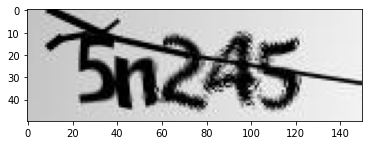

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow((train_dataset[0][0][0].to('cpu').numpy()), cmap='gray')

#Создание и обучение модели

После прочтения статьи о предлагаемой архитектуре, у меня сложилось мнение, что модель является 'оверхедом' для данной задачи и быстро переобучится. Так как в требуемой задаче длина последовательности константная и символы на каждом изображении находятся в почти тех же местах, связи между символами нет. Поэтому я решил взять только подход к извлечению векторов из изображений, а далее вместо LSTM - просто линейный слой. 

In [55]:
loss = nn.CrossEntropyLoss()
train_logs_list = [[]]
val_logs_list = []
best_loss = 1e9
cer = CharErrorRate()

def loss_function(x, label):
    global loss 
    x = torch.permute(x,(0,2,1))
    return loss(x, label)

def tensor_to_list(x):
    out = []
    for i in x:
        s = ""
        for j in i:
            s += index_to_char[j]
        out.append(s)
    return out

In [56]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
        nn.Conv2d(1, 64,(3,3)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((2,3)),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128,(3,5)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((2,3)),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128,(3,5)),
        nn.ReLU(inplace=True),
        nn.AdaptiveMaxPool2d((5,5))
        )
        self.lin_layer = nn.Parameter(torch.rand(640,36))
    
    def forward(self, X: torch.Tensor):
        x = self.conv_layers(X)
        x = torch.reshape(x, (-1,640,5))
        x = torch.einsum('bij,ik->bjk', x, self.lin_layer)
        return x

In [57]:
class Classifier(LightningModule):
          
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_func = loss_function

    def training_step(self, batch, batch_idx):
        x, y, res = batch

        pred = self.model(x)
            
        loss = self.loss_func(pred, y)

        _, out = torch.max(pred.data, -1)
        out = tensor_to_list(out)
            
        train_logs_list[-1].append(loss.item()) 
            
        return {"loss": loss, "out": out, "res": res}

    def training_epoch_end(self, outputs):
        model_out, res = [], []
        for i in outputs:
            model_out.extend(i['out'])
            res.extend(i['res'])
        x = np.array(train_logs_list[-1])
        train_logs_list.pop()
        train_logs_list.append(x.mean())
        self.log("train_loss", train_logs_list[-1], prog_bar=True)
        self.log("CER_train", cer(model_out, res), prog_bar=True)
        train_logs_list.append([])

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=1e-1, total_steps=self.trainer.estimated_stepping_batches
        )
        return [optimizer], [scheduler]


    
    def validation_step(self, batch, batch_idx):
        global best_loss
        x, y, res = batch
        pred = self.model(x) 

        _, pred = torch.max(pred.data, -1)
        out = tensor_to_list(pred)
        
        return {"out": out, "res": res}

    def validation_epoch_end(self, outp):
        model_out, res = [], []
        for i in outp:
            model_out.extend(i["out"])
            res.extend(i["res"])
        global best_loss
        loss = cer(model_out, res)
        val_logs_list.append(loss)
        if val_logs_list[-1] < best_loss and len(val_logs_list)>3:
            self.save()
            best_loss = val_logs_list[-1]
        self.log("CER_val", val_logs_list[-1], prog_bar=True)

    def save(self):
        path = "/content/best_params"
        torch.save(self.model.state_dict(), path)

In [58]:
lightning_model = Classifier(Model())
        
checkpoint_callback = ModelCheckpoint(monitor="train_loss",save_top_k = 3)
callbacks = [checkpoint_callback]
        
trainer = Trainer(gpus=1,max_epochs=100, callbacks=callbacks, num_sanity_val_steps=0)


trainer.fit(lightning_model, train_loader, val_dataloaders = val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | Model | 392 K 
--------------------------------
392 K     Trainable params
0         Non-trainable params
392 K     Total params
1.572     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [59]:
print("Best val loss", best_loss.item())

Best val loss 0.022429905831813812


#Подсчет метрик

In [60]:
model = Model()
model.load_state_dict(torch.load('/content/best_params'))
model.eval()

Model(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 128, kernel_size=(3, 5), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): AdaptiveMaxPool2d(output_size=(5, 5))
  )
)

In [61]:
model_out, res = [], []
all_result = []
with torch.no_grad():
    for i in test_dataset:
        a = model(i[0][None,:])
        _, a = torch.max(a,-1)
        model_out.append(tensor_to_list(a)[0])
        res.append(i[2])
        all_result.append([model_out[-1], res[-1], cer(model_out[-1], [res[-1]]).item()])


In [63]:
print("Test loss", best_loss.item())

Test loss 0.022429905831813812


#Анализ ошибок модели

In [84]:
worst = sorted(all_result,reverse = True, key=lambda x: x[2])[:16]
worst

[['wm4f7', 'wm47f', 0.4000000059604645],
 ['mffc5', 'mfc35', 0.4000000059604645],
 ['nmyy2', 'nmy2x', 0.4000000059604645],
 ['ywn66', 'yw667', 0.4000000059604645],
 ['m8gmn', 'm8gmx', 0.20000000298023224],
 ['xfm6n', 'xfn6n', 0.20000000298023224],
 ['cp85x', 'ep85x', 0.20000000298023224],
 ['fcnc6', 'fcne6', 0.20000000298023224],
 ['nybcc', 'nybcx', 0.20000000298023224],
 ['4ce4p', '47e4p', 0.20000000298023224],
 ['4w36g', '4w76g', 0.20000000298023224],
 ['m22f4', 'm2nf4', 0.20000000298023224],
 ['degp5', 'deep5', 0.20000000298023224],
 ['n3m65', 'n3m6x', 0.20000000298023224],
 ['cnwyg', 'cnwyc', 0.20000000298023224],
 ['d2nbn', 'd2nbn', 0.0]]

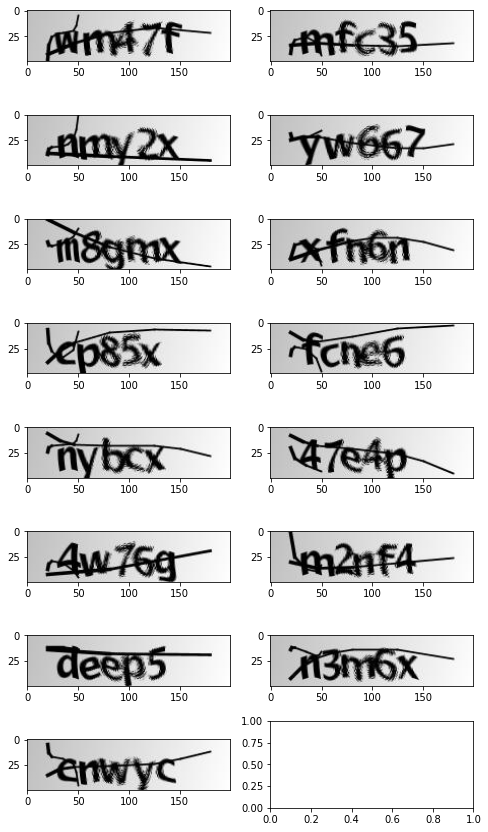

In [83]:
fig, axes = plt.subplots(8, 2, figsize=(8, 15))

for axis, i in zip(axes.flat, worst):
    image = plt.imread('/content/test/'+i[1] + '.png')
    axis.imshow(image, cmap='gray')

На некоторых изображениях линия, перечеркивая последовательность, создает ассоциации с другими буквами. Особенно хорошо это можно заметить на изображении 'cp85x' (буква 'c' очень похожа на 'e'). Возможно, это потому что модели не хватает степеней свободы, что бы выучить все зависимости. Что бы решить данную проблему, я бы сперва попытался увеличить обьем выборки, что позволит получать более точную оценку модели и параметров. Также можно увеличить количество параметров (например добавить линейный слой после сверток).